In [1]:
# kaggle competitions submit -c [COMPETITION] -f [FILE] -m [MESSAGE]: make a competition submission



In [ ]:
import pyarrow.parquet as pa
import pandas as pd



In [75]:
tbl = pa.read_table('jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet').to_pandas()

In [ ]:
# schema = pa.read_schema('jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet')
# tbllags = pa.read_table('jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet', schema=schema).to_pandas()

In [ ]:
#symbol : financial instrument (20 in the parquet)
# Transformer - input - seq of n instruments, window (60) * n features, to predict outcome of each instrument
# embedding of window * n features (60 * 100) to a fixed size vector (1024)

# VAR model

In [ ]:

tbl['symbol_id'].value_counts()

20

,date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,...,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
3,0,0,10,0.690606,1.139366,0.273328,0.306549,-1.262223,42,5,...,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516,0
11,0,1,10,0.690606,1.574611,-0.463503,0.057437,-0.797103,42,5,...,0.249527,0.324737,0.894854,2.433310,1.498122,2.685856,3.405593,1.713544,3.902426,0
19,0,2,10,0.690606,0.901914,0.248612,0.235444,-0.794990,42,5,...,-1.273521,-0.405011,-2.040782,-0.333981,0.883624,-1.165902,1.392162,1.455869,0.799255,0
27,0,3,10,0.690606,1.020276,0.294999,0.232703,-0.581421,42,5,...,-0.991729,-0.415453,-1.312333,-0.490409,0.455933,-1.522753,0.729087,0.940686,-0.281881,0
35,0,4,10,0.690606,1.130208,0.408359,0.436288,-0.645128,42,5,...,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,0.325985,0.845082,0.119153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944122,169,844,10,1.244815,-0.042858,0.311658,0.106930,-0.827049,42,5,...,0.941421,0.440664,-2.152214,-0.227276,-0.079979,-2.007191,-0.090477,-0.000840,-0.388896,0
1944141,169,845,10,1.244815,-0.127553,-0.461911,-0.093769,-0.722514,42,5,...,1.236159,0.328857,-0.442078,-0.100044,-0.078303,-0.396530,0.062065,0.030690,0.123374,0
1944160,169,846,10,1.244815,-0.272587,-0.959866,-0.562219,-0.571135,42,5,...,0.052241,0.457515,5.000000,-0.092042,-0.062944,5.000000,0.058293,0.070101,0.081584,0
1944179,169,847,10,1.244815,-0.011593,0.631709,0.174070,-0.995610,42,5,...,0.932231,1.228120,4.537508,0.900455,0.652371,5.000000,0.142540,0.106125,0.368507,0


In [ ]:
# 78 features, 8 targets
# dropped 9 columns
drop_threshold = 0.5
print((tbl.isna().sum() <tbl.shape[0]*drop_threshold).sum(), tbl.shape[1])
tbl = tbl[tbl.columns[tbl.isna().sum() <tbl.shape[0]*drop_threshold]] 

84


In [177]:
# should add lags of time (to show gap in time)
# consider the lags issue by adding lags of responders
selected = tbl.loc[tbl['symbol_id'] == 0].loc[ tbl['date_id']==1]

In [180]:
from statsmodels.tsa.stattools import adfuller

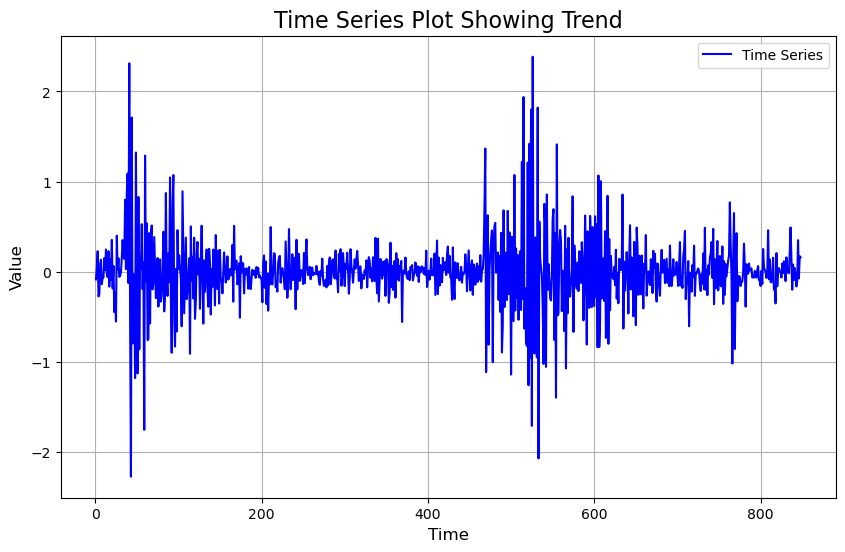

In [179]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(selected['time_id'], selected['feature_05'].diff(), label="Time Series", color="blue")
plt.title("Time Series Plot Showing Trend", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

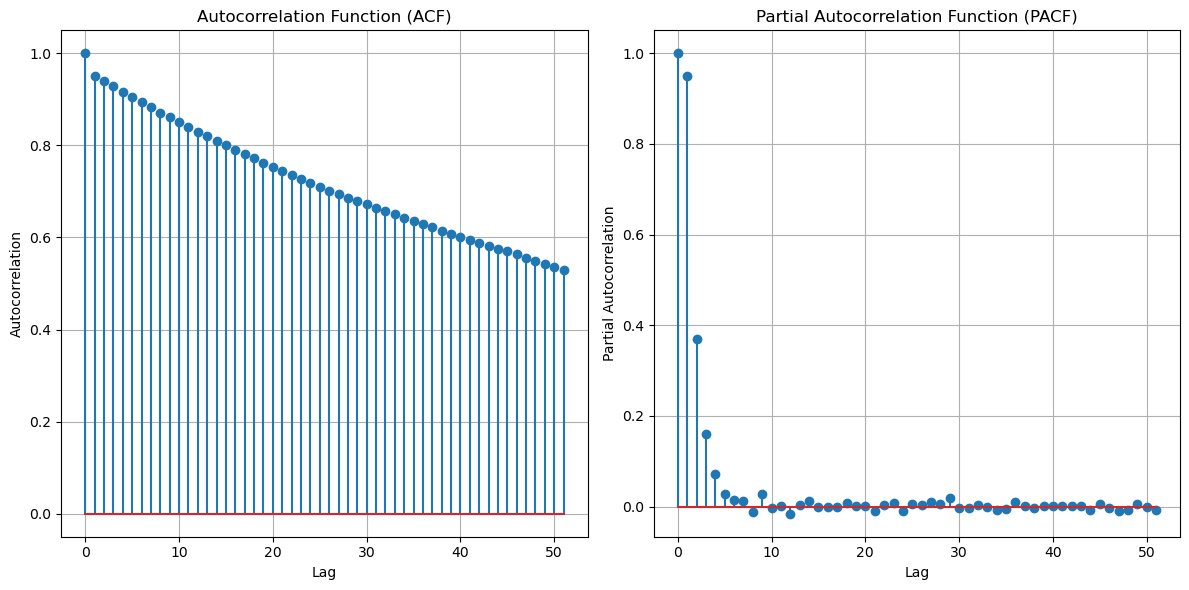

In [113]:
from statsmodels.tsa.stattools import acf, pacf
acf_values = acf(selected['feature_05'])
pacf_values = pacf(selected['feature_05'])
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot ACF
ax[0].stem(range(len(acf_values)), acf_values)
ax[0].set_title("Autocorrelation Function (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid()

# Plot PACF
ax[1].stem(range(len(pacf_values)), pacf_values)
ax[1].set_title("Partial Autocorrelation Function (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
tbl.loc[tbl['symbol_id']==10]

,date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,...,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
0,0,0,1,3.889038,0.851033,0.242971,0.263400,-0.891687,11,7,...,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504,0
1,0,0,7,1.370613,0.676961,0.151984,0.192465,-0.521729,11,7,...,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639,0
2,0,0,9,2.285698,1.056285,0.187227,0.249901,-0.773050,11,7,...,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828,0
3,0,0,10,0.690606,1.139366,0.273328,0.306549,-1.262223,42,5,...,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516,0
4,0,0,14,0.440570,0.955200,0.262404,0.344457,-0.613813,44,3,...,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944195,169,848,7,1.789037,-0.014222,0.226235,0.101985,-0.500298,11,7,...,2.690954,1.854106,5.000000,1.295612,0.370915,2.651581,-1.344183,-0.526427,-2.111102,0
1944196,169,848,8,1.665622,-0.027113,0.217258,0.127194,-0.554156,15,1,...,-1.952719,0.753256,1.753474,0.753926,0.347689,1.002481,-0.953408,-0.330281,-0.981245,0
1944197,169,848,9,1.892650,-0.024533,0.182804,0.082487,-0.540154,11,7,...,1.453674,0.949433,-1.063989,0.738098,0.540964,0.030697,-0.017320,0.019186,-0.019747,0
1944198,169,848,10,1.244815,-0.024115,0.385268,0.134953,-0.574861,42,5,...,1.014766,1.044241,5.000000,0.914982,0.644817,5.000000,0.138480,0.103964,0.237636,0


In [ ]:
tbl = tbl.iloc[:,:92]
X = tbl.iloc[:,:-8]
y = tbl.iloc[:,-8:]

In [20]:

from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
import torch
import numpy as np

In [42]:
cutoff = -100000
train_dataset = TensorDataset(torch.tensor(X[:cutoff].values), torch.tensor(y[:cutoff].values))
val_dataset = TensorDataset(torch.tensor(X[cutoff:].values), torch.tensor(y[cutoff:].values))

In [43]:
bs =2048
trainloader = DataLoader(train_dataset, batch_size=bs, shuffle=False)
valloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

In [44]:
# tscv = TimeSeriesSplit(n_splits=5, test_size = X.shape[0]//200)
# combine the indices for the 5 splits into one for train and val, and initialize ONE dataloader

In [45]:
X.shape

(1944210, 84)

In [46]:
X.shape

(1944210, 84)

In [19]:
train_idx.shape

(1895605,)

In [ ]:
train_subset = Subset(dataset, tscv.split(X)[0][0])